In [1]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [2]:
# Constants
DATA = 'RestrictedImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 8
NOISE_SCALE = 20

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

In [3]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset restricted_imagenet..


In [4]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): SequentialWithArgs(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [5]:
# Custom loss for inversion
def inversion_loss(model, inp, targ):
    _, rep = model(inp, with_latent=True, fake_relu=True)
    loss = ch.div(ch.norm(rep - targ, dim=1), ch.norm(targ, dim=1))
    return loss, None

In [6]:
# PGD parameters
kwargs = {
    'custom_loss': inversion_loss,
    'constraint':'2',
    'eps':1000,
    'step_size': 1,
    'iterations': 10000, 
    'do_tqdm': True,
    'targeted': True,
    'use_best': False
}

In [7]:
# Select images to invert (random samples from the test set)

_, (im, targ) = next(data_iterator) # Images to invert

with ch.no_grad():
    (_, rep), _ = model(im.cuda(), with_latent=True) # Corresponding representation 

In [8]:
im_n = ch.randn_like(im) / NOISE_SCALE + 0.5 # Seed for inversion (x_0)

_, xadv = model(im_n, rep.clone(), make_adv=True, **kwargs) # Image inversion using PGD

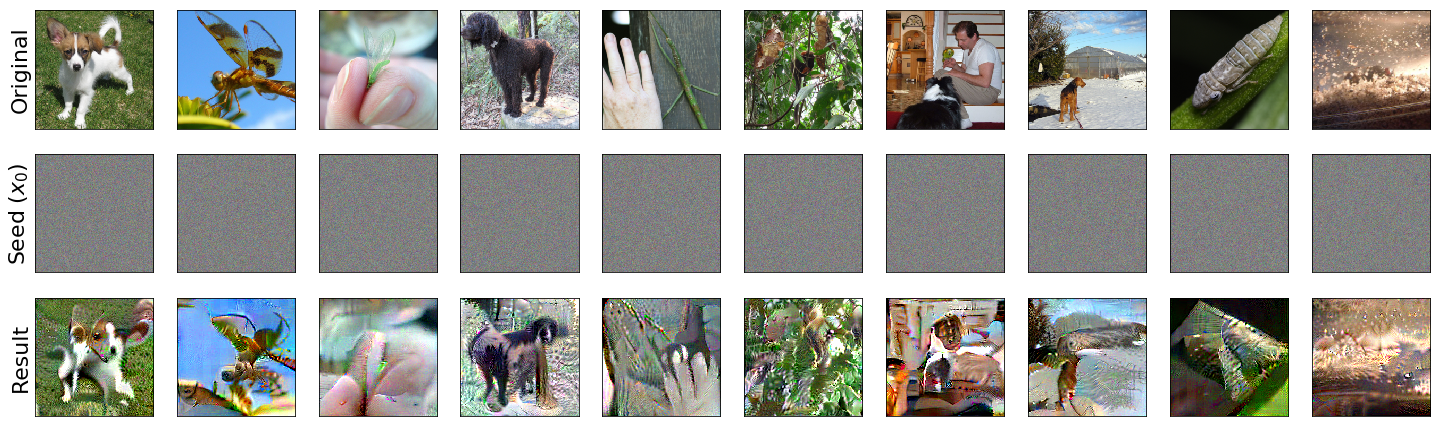

In [9]:
# Visualize inversion
show_image_row([im.cpu(), im_n.cpu(), xadv.detach().cpu()], 
               ["Original", r"Seed ($x_0$)", "Result"], 
               fontsize=22)